# Sentiment Analysis (non-English)

In [1]:
!pip install stanza

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 18.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [9]:
# Load data
import json
import pandas as pd
import torch
import numpy as np

# Preprocessing
import re
import nltk
from nltk.corpus import stopwords
import stanza
from bs4 import BeautifulSoup
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset

# Training
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import os

# Evaluation and plots
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import seaborn as sns
import spacy

In [27]:
 !python -m spacy download nl_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('nl_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
print(stopwords.fileids())

['albanian', 'arabic', 'azerbaijani', 'basque', 'belarusian', 'bengali', 'catalan', 'chinese', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hebrew', 'hinglish', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'tamil', 'turkish']


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Datasets

In [6]:
def load_dataset_splits(train_path, val_path, test_path):
    train = pd.read_csv(train_path)
    val = pd.read_csv(val_path)
    test = pd.read_csv(test_path)
    return train, val, test

In [7]:
def drop_columns(train, val, test, cols, label_col):
    if cols != None:
        train = train.drop(columns=cols)
        val = val.drop(columns=cols)
        test = test.drop(columns=cols)

    train["labels"] = train[label_col]
    val["labels"] = val[label_col]
    test["labels"] = test[label_col]

    train = train.drop(columns=[label_col])
    val = val.drop(columns=[label_col])
    test = test.drop(columns=[label_col])

    return train, val, test

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Preprocessing

In [ ]:
# Compute class weights
def get_class_weights(train_labels, classes, device):
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=train_labels
    )
    return torch.tensor(class_weights, dtype=torch.float).to(device)

def compute_class_weights(train_df, classes, device):
    # Get weights for loss function
    train_labels = train_df['labels'].values
    class_weights = get_class_weights(train_labels, classes, device)

    # Define weighted loss function
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

    return loss_fn

In [ ]:
class TextPreprocessor:
    def __init__(self, remove_stopwords=True, apply_lemmatization=True, stopwords=None):
        self.remove_stopwords = remove_stopwords
        self.apply_lemmatization = apply_lemmatization
        self.stopwords = stopwords if stopwords else set()

    def clean_text(self, text):
        """Preprocess a single text instance."""
        if pd.isna(text):
            return ""  # Handle missing values

        text = text.lower()  # Lowercase all text

        text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags

        text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs

        text = re.sub(r"([а-яА-Я])\1{2,}", r"\1", text)  # Reduce repeated letters (Bulgarian support)

        text = re.sub(r"[^\w\s]", " ", text)  # Remove excessive punctuation

        text = re.sub(r"\s+", " ", text).strip()  # Remove extra whitespace

        # Tokenization and Lemmatization using Stanza
        doc = nlp(text)
        tokens = [word.lemma for sent in doc.sentences for word in sent.words]

        if self.remove_stopwords:
            tokens = [word for word in tokens if word not in self.stopwords]

        return " ".join(tokens)  # Reconstruct cleaned text

    def preprocess_dataframe(self, df, text_col):
        """Apply preprocessing to an entire dataset."""
        df[text_col] = df[text_col].astype(str).apply(self.clean_text)
        return df

In [29]:
class TextPreprocessor_2:
    def __init__(self, remove_stopwords=True, apply_lemmatization=True):
        self.remove_stopwords = remove_stopwords
        self.apply_lemmatization = apply_lemmatization
        self.stop_words = set(stopwords.words("dutch"))  # Use Dutch stopwords
        self.nlp = spacy.load("nl_core_news_sm")  # Load Dutch spaCy model

    def clean_text(self, text):
        """Preprocess a single text instance."""
        if pd.isna(text):
            return ""  # Handle missing values

        text = text.lower()  # Lowercase all text
        text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags
        text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
        text = re.sub(r"[^\x00-\x7F]+", "", text)  # Remove non-ASCII characters
        text = re.sub(r"([a-z])\1{2,}", r"\1", text)  # Reduce repeated letters
        text = re.sub(r"[^\w\s]", " ", text)  # Remove excessive punctuation
        text = re.sub(r"\s+", " ", text).strip()  # Remove extra whitespace

        # Tokenization and Lemmatization using spaCy
        doc = self.nlp(text)
        tokens = [token.lemma_ for token in doc] if self.apply_lemmatization else [token.text for token in doc]

        # Remove stopwords
        if self.remove_stopwords:
            tokens = [word for word in tokens if word not in self.stop_words]

        return " ".join(tokens)  # Reconstruct cleaned text

    def preprocess_dataframe(self, df, text_col):
        """Apply preprocessing to an entire dataset."""
        df[text_col] = df[text_col].astype(str).apply(self.clean_text)
        return df


In [ ]:
# Tokenizer for multilingual BERT
tokenizer = AutoTokenizer.from_pretrained("rmihaylov/bert-base-bg")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/3.34M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.12M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

In [ ]:
tokenizer.pad_token_id = 0

In [28]:
# Now use the Hugging Face tokenizer for the final tokenization
#def tokenize_texts(texts):
    #return tokenizer(texts, padding=True, truncation=True, max_length=256, return_tensors="pt")

def tokenize_texts(texts):
    encoding = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    # Ensure that the attention mask reflects the new pad token ID
    encoding['attention_mask'] = torch.where(
        encoding['input_ids'] == tokenizer.pad_token_id, torch.tensor(0), torch.tensor(1)
    )

    return encoding


def preprocess_dataset(train, val, test, text_col):
    #preprocessor = TextPreprocessor(remove_stopwords=True, apply_lemmatization=True, stopwords=bulgarian_stopwords)
    preprocessor = TextPreprocessor_2(remove_stopwords=True, apply_lemmatization=True)
    train = preprocessor.preprocess_dataframe(train, text_col)
    val = preprocessor.preprocess_dataframe(val, text_col)
    test = preprocessor.preprocess_dataframe(test, text_col)
    return train, val, test

def tokenization(train, val, test, label_col, text_col):
    # Ensure 'translated_text' column is converted to a list of strings
    train_texts = train[text_col].astype(str).tolist()  # Convert to list of strings
    val_texts = val[text_col].astype(str).tolist()      # Convert to list of strings
    test_texts = test[text_col].astype(str).tolist()    # Convert to list of strings

    # Tokenize the preprocessed data
    train_encodings = tokenize_texts(train_texts)
    val_encodings = tokenize_texts(val_texts)
    test_encodings = tokenize_texts(test_texts)

    # Convert labels to the format expected by the model
    train_encodings[label_col] = torch.tensor(pd.Series(train[label_col]).values)
    val_encodings[label_col] = torch.tensor(pd.Series(val[label_col]).values)
    test_encodings[label_col] = torch.tensor(pd.Series(test[label_col]).values)

    return train_encodings, val_encodings, test_encodings

In [15]:
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        print(self.encodings['input_ids'][0])  # Check the tokenized sequence
        print("\n")
        print(self.encodings['attention_mask'][0])  # Check the attention mask

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

## Train the model

In [16]:
def load_model(df, model_name):
    num_labels = len(set(df['labels']))
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    return model.to(device)

In [ ]:
class CustomTrainer(Trainer):
    def __init__(self, *args, loss_fn=None, **kwargs):
      super().__init__(*args, **kwargs)
      self.loss_fn = loss_fn

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")  # Get the true labels
        outputs = model(**inputs)  # Get model outputs
        logits = outputs.get("logits")  # Get the logits (raw predictions)

        # Compute the weighted loss
        loss = self.loss_fn(logits, labels)

        # Return loss, and optionally, the outputs (for debugging/metrics)
        return (loss, outputs) if return_outputs else loss

In [ ]:
class model_training:
    def __init__(self, train_dataset=None, val_dataset=None, tokenizer=None, model=None, loss_fn=None):
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.tokenizer = tokenizer
        self.model = model
        self.loss_fn = loss_fn

    @staticmethod
    def compute_metrics(p):
        preds = p.predictions.argmax(-1)  # Get predicted labels
        labels = p.label_ids  # True labels

        # Calculate accuracy
        accuracy = accuracy_score(labels, preds)

        # Calculate precision, recall, and F1 score
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    def main(self):
        training_args = TrainingArguments(
            output_dir="/content/drive/MyDrive/Leiden Uni/Thesis/checkpoints",
            evaluation_strategy="steps",
            eval_steps=500,
            save_strategy="steps",
            save_steps=500,
            save_total_limit=3,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            num_train_epochs=3,
            weight_decay=0.01,
            remove_unused_columns=False,
            load_best_model_at_end=True,
            report_to="none"  # Disables wandb logging
        )

        # Look for the latest checkpoint
        checkpoint_dir = training_args.output_dir
        last_checkpoint = None

        if os.path.isdir(checkpoint_dir):
            checkpoints = [d for d in os.listdir(checkpoint_dir) if d.startswith("checkpoint-")]
            if checkpoints:
                last_checkpoint = os.path.join(checkpoint_dir, sorted(checkpoints, key=lambda x: int(x.split('-')[-1]))[-1])
        if last_checkpoint:
            print(f"Resuming training from checkpoint: {last_checkpoint}")
        else:
            print("No checkpoint found, starting from scratch.")

        if self.loss_fn != None:
            trainer = CustomTrainer(
                model=self.model,
                args=training_args,
                train_dataset=self.train_dataset,
                eval_dataset=self.val_dataset,
                tokenizer=self.tokenizer,
                compute_metrics=self.compute_metrics,
                loss_fn=self.loss_fn
            )
        else:
            trainer = Trainer(
              model=self.model,
              args=training_args,
              train_dataset=self.train_dataset,
              eval_dataset=self.val_dataset,
              tokenizer=self.tokenizer,
              compute_metrics=self.compute_metrics
            )

        return trainer, last_checkpoint

## Evaluate

In [ ]:
def plot_confusion_mat(labels, preds):
    cm = confusion_matrix(labels, preds)

    # Define class labels (modify as needed)
    class_labels = ["Negative", "Neutral", "Positive"]  # Adjust based on dataset

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
def get_predictions(model, dataset, device, last_checkpoint):
    model.eval()  # Set model to evaluation mode
    predictions, true_labels = [], []

    # Create DataLoader
    dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=4)

    # Loop through the DataLoader with tqdm progress bar
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting", unit="batch"):  # tqdm adds a progress bar here
            inputs = {k: v.to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
            labels = batch["labels"].to(device)

            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=-1)  # Get predicted class

            predictions.extend(preds.cpu().numpy())  # Move to CPU and store
            true_labels.extend(labels.cpu().numpy())  # Move to CPU and store

    return np.array(predictions), np.array(true_labels)

## Bulgarian

### Load Dataset

In [ ]:
# Load the dataset splits (train, validation and test)

train_bg = pd.read_json('/content/train.jsonl', lines=True)
val_bg = pd.read_json('/content/dev.jsonl', lines=True)
test_bg = pd.read_json('/content/test.jsonl', lines=True)

train_bg.head()

,ID,Cinexio_URL,Comment,User_Rating,Date,Category
0,0,http://www.cinexio.com/sofia/movie/122,Пет звезди са му малко - заслужава поне още то...,5.0,2013-01-21,2
1,1,http://www.cinexio.com/sofia/movie/122,"За гледане на кино, но ми беше малко муден.",3.0,2013-11-30,1
2,2,http://www.cinexio.com/sofia/movie/122,"Повече приказка от колкото екшън, но също така...",5.0,2013-03-12,2
3,3,http://www.cinexio.com/sofia/movie/122,Добър филм.,5.0,2013-08-12,2
4,4,http://www.cinexio.com/sofia/movie/122,да тъжно. УХЖГДЗТФВСАФСАЧММММММККЖГОШШШШЖБЙЙЙ...,2.5,2014-11-22,1


In [ ]:
# Drop unnecessary columns and rename label column to "labels"
cols_bg_drop = ["ID", "Cinexio_URL", "User_Rating", "Date"]
train_bg, val_bg, test_bg = drop_columns(train_bg, val_bg, test_bg, cols_bg_drop, "Category")
train_bg.head()

,Comment,labels
0,Пет звезди са му малко - заслужава поне още то...,2
1,"За гледане на кино, но ми беше малко муден.",1
2,"Повече приказка от колкото екшън, но също така...",2
3,Добър филм.,2
4,да тъжно. УХЖГДЗТФВСАФСАЧММММММККЖГОШШШШЖБЙЙЙ...,1


### Preprocess dataset

In [ ]:
# Load Bulgarian stopwords from JSON
with open("/content/stopwords-bg.json", "r", encoding="utf-8") as f:
    bulgarian_stopwords = set(json.load(f))

# Initialize Stanza for Bulgarian NLP processing
stanza.download("bg")
nlp = stanza.Pipeline(lang="bg", processors="tokenize,lemma")

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: bg (Bulgarian) ...


INFO:stanza:Downloaded file to /root/stanza_resources/bg/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: bg (Bulgarian):
| Processor | Package      |
----------------------------
| tokenize  | btb          |
| lemma     | btb_nocharlm |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [ ]:
# Compute the weighted loss function
classes_bg = np.array([0, 1, 2]) # Negative=0, Neutral=1, Positive=2
loss_bg = compute_class_weights(train_bg, classes_bg, device)

In [ ]:
# Clean the dataset
train_bg, val_bg, test_bg = preprocess_dataset(train_bg, val_bg, test_bg, 'Comment')
train_bg.head()

,Comment,labels
0,пет звезда мой заслужавам,2
1,гледане кино муден,1
2,приказка колкото екшън грабващ внимание власте...,2
3,филм,2
4,тъжно ухжгдзтфвсафсачмккжгошжбйхн кбжнлйхбхфгф...,1


In [ ]:
# Tokenization
train_bg_encodings, val_bg_encodings, test_bg_encodings = tokenization(train_bg, val_bg, test_bg, "labels", "Comment")

Pad token ID: 119547
Pad token ID: 119547
Pad token ID: 119547

In [ ]:
# Creating the dataset
train_bg_dataset = SentimentDataset(train_bg_encodings, train_bg_encodings['labels'])
val_bg_dataset = SentimentDataset(val_bg_encodings, val_bg_encodings['labels'])
test_bg_dataset = SentimentDataset(test_bg_encodings, test_bg_encodings['labels'])

tensor([    2,   475,  2737,  2106, 46996,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0])


tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([    2,    21, 45777,   100,    27,  6601, 27893,  1965,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0])


tensor([1, 1, 1, 1, 1, 1, 1, 1

### Training

In [ ]:
model_bg = load_bg_model(train_bg)

config.json:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/712M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at rmihaylov/bert-base-bg and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_bg = model_training(
                  train_dataset=train_bg_dataset,
                  val_dataset=val_bg_dataset,
                  tokenizer=tokenizer,
                  model=model_bg,
                  loss_fn=loss_bg
              )
trainer_bg, last_checkpoint_bg = training_bg.main()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


No checkpoint found, starting from scratch.


<ipython-input-16-7502dd44e21a>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [ ]:
# Resume training from the last checkpoint if it exists
trainer_bg.train(resume_from_checkpoint=last_checkpoint_bg)

<ipython-input-14-488c43f4a95a>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.847100,0.695454,0.796547,0.682572,0.666369,0.671657
1000,0.660100,0.664675,0.781751,0.657943,0.688161,0.669851
1500,0.508000,0.708591,0.779285,0.675685,0.695824,0.680597


<ipython-input-14-488c43f4a95a>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-14-488c43f4a95a>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-14-488c43f4a95a>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


TrainOutput(global_step=1530, training_loss=0.6702131819880865, metrics={'train_runtime': 426.3208, 'train_samples_per_second': 57.386, 'train_steps_per_second': 3.589, 'total_flos': 842350926242070.0, 'train_loss': 0.6702131819880865, 'epoch': 3.0})

### Evaluate

In [ ]:
trainer_bg.evaluate()

<ipython-input-14-488c43f4a95a>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.6646754741668701,
 'eval_accuracy': 0.781750924784217,
 'eval_precision': 0.65794343322513,
 'eval_recall': 0.6881614372993683,
 'eval_f1': 0.6698514297235851,
 'eval_runtime': 1.5379,
 'eval_samples_per_second': 527.359,
 'eval_steps_per_second': 33.163,
 'epoch': 3.0}

In [ ]:
trainer_bg.evaluate(test_bg_dataset)

<ipython-input-14-488c43f4a95a>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 3.2366371154785156,
 'eval_accuracy': 0.156794425087108,
 'eval_precision': 0.3333333333333333,
 'eval_recall': 0.05226480836236933,
 'eval_f1': 0.09036144578313253,
 'eval_runtime': 1.9892,
 'eval_samples_per_second': 432.829,
 'eval_steps_per_second': 27.146,
 'epoch': 3.0}

In [ ]:
# Checkpoint path
last_checkpoint_bg = "/content/drive/MyDrive/Leiden Uni/Thesis/checkpoints/checkpoint-1530"

preds_bg, labels_bg = get_predictions(model_bg, test_bg_dataset, device, last_checkpoint_bg)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Predicting:   0%|          | 0/54 [00:00<?, ?batch/s]<ipython-input-14-488c43f4a95a>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-14-488c43f4a95a>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gra

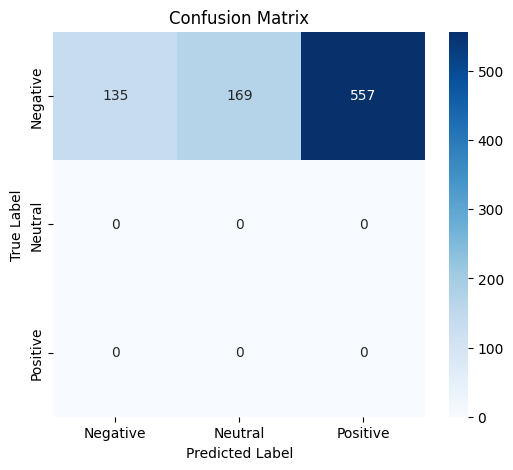

In [ ]:
plot_confusion_mat(labels_bg, preds_bg)

## Dutch

### Load Dataset

In [18]:
# Load the dataset splits (train, validation and test)
train_nl = pd.read_csv('/content/train.csv')
val_nl = pd.read_csv('/content/val.csv')
test_nl = pd.read_csv('/content/test.csv')

train_nl.head()

,text,label
0,Het verhaaltje op de achterkant klonk heel int...,0
1,Joy Fielding is geboren en getogen in Toronto....,0
2,Begint goed. Op de vlucht steeds hetzelfde sce...,0
3,Ben er toch weer ingetrapt. Als een schaap ach...,0
4,"Kruisverhoor heb ik maar tot de helft gelezen,...",0


### Preprocess dataset

In [19]:
# Tokenizer for multilingual BERT
tokenizer_nl = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")

In [ ]:
# Clean the dataset
train_nl, val_nl, test_nl = preprocess_dataset(train_nl, val_nl, test_nl, 'text')
train_nl.head()

<ipython-input-29-29f17dc147eb>:14: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags


,text,label
0,verhaal achterkant klinken heel interessant sc...,0
1,Joy fielding geboren getoag Toronto studeren e...,0
2,beginnen goed vlucht steeds hetzelfde scenario...,0
3,weer ingetrappen schaap achter kudde lopen 60 ...,0
4,kruisverhoor helft lezen verhaal terugtrekken ...,0


In [ ]:
# Tokenization
train_bl_ncodings, val_bg_encodings, test_bg_encodings = tokenization(train_bg, val_bg, test_bg, "labels", "Comment")